In [1]:
pip install split-folders

In [2]:
import kagglehub
import os
import splitfolders
import math
import tensorflow as tf, numpy as np
from collections import Counter
from tensorflow.keras.applications.efficientnet import preprocess_input
from pathlib import Path
from collections import Counter
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from tensorflow.keras.layers import Layer, Conv2D, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Activation, Multiply, Concatenate, Input, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import layers as L, Model
from tensorflow.keras.optimizers import Adam


In [3]:
# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

100%|██████████| 40.8M/40.8M [00:00<00:00, 96.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1


In [4]:
sub_path = os.path.join(path, "dataset-resized")
subfolders = [f for f in os.listdir(sub_path) if os.path.isdir(os.path.join(sub_path, f))]
print(subfolders)

['plastic', 'paper', 'trash', 'glass', 'metal', 'cardboard']


In [5]:
base_path = os.path.join(path, "dataset-resized")
output_dir = "/content/Split"

# ratio can be adjusted, e.g. (0.8, 0.1, 0.1)
splitfolders.ratio(base_path, output=output_dir, seed=1337, ratio=(.8, .1, .1))

Copying files: 2527 files [00:00, 3206.64 files/s]


In [6]:
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir  = os.path.join(output_dir, "test")

In [8]:
CFG = {
    "dataset_root": "/content/Split",   # change per dataset
    "img_size": (224, 224),                  # EfficientNetB0 likes 224; B3 likes 300; set once
    "batch_size": 32,
    "seed": 42,
    "backbone": "efficientnetb0",            # "efficientnetb0"|"efficientnetb3"|"mobilenetv3large"
    "use_mixed_precision": True
}

def make_splits(root):
    root = Path(root)
    # has_val = (root/"val").exists()
    train_ds = tf.keras.utils.image_dataset_from_directory(
            root/"train", image_size=CFG["img_size"], batch_size=CFG["batch_size"],
            seed=CFG["seed"], shuffle=True
        )
    val_ds = tf.keras.utils.image_dataset_from_directory(
            root/"val", image_size=CFG["img_size"], batch_size=CFG["batch_size"],
            seed=CFG["seed"], shuffle=False
        )
    test_ds = tf.keras.utils.image_dataset_from_directory(
            root/"test", image_size=CFG["img_size"], batch_size=CFG["batch_size"],
            seed=CFG["seed"], shuffle=False
        )
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = make_splits(CFG["dataset_root"])
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

Found 2019 files belonging to 6 classes.
Found 251 files belonging to 6 classes.
Found 257 files belonging to 6 classes.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.05),
])

# Use the matching preprocess for your backbone
if CFG["backbone"].startswith("efficientnet"):
    from tensorflow.keras.applications.efficientnet import preprocess_input
elif CFG["backbone"].startswith("mobilenetv3"):
    from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
else:
    preprocess_input = lambda x: x

def prep(ds, training=False):
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(AUTOTUNE)

train_ds = prep(train_ds, training=True)
val_ds   = prep(val_ds,   training=False)
test_ds  = prep(test_ds,  training=False) if test_ds is not None else None

In [10]:
counts = Counter(int(y.numpy()) for _, y in train_ds.unbatch().take(10**9))
total = sum(counts.values())
class_weight = {c: total/(NUM_CLASSES*counts[c]) for c in range(NUM_CLASSES)}
print("class_weight:", class_weight)

class_weight: {0: 1.045031055900621, 1: 0.84125, 2: 1.0259146341463414, 3: 0.708421052631579, 4: 0.874025974025974, 5: 3.0871559633027523}


In [40]:
@keras.saving.register_keras_serializable()
class ChannelAttention(L.Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        # Accept **kwargs so Keras can pass name, dtype, etc.
        super().__init__(**kwargs)
        self.filters = int(filters)
        self.reduction = int(reduction)
        # Dense layers created in build()

    def build(self, input_shape):
        hidden = max(1, self.filters // self.reduction)
        self.fc1 = L.Dense(hidden, activation="relu", name=self.name + "_mlp_1")
        self.fc2 = L.Dense(self.filters, name=self.name + "_mlp_2")
        super().build(input_shape)

    def call(self, x):
        # x: [B,H,W,C]
        avg = tf.reduce_mean(x, axis=[1, 2])      # [B, C]
        max_ = tf.reduce_max(x, axis=[1, 2])      # [B, C]
        avg_out = self.fc2(self.fc1(avg))
        max_out = self.fc2(self.fc1(max_))
        scale = tf.nn.sigmoid(avg_out + max_out)  # [B, C]
        scale = tf.reshape(scale, [-1, 1, 1, self.filters])
        return x * scale

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"filters": self.filters, "reduction": self.reduction})
        return cfg


@keras.saving.register_keras_serializable()
class SpatialAttention(L.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = int(kernel_size)
        # conv created in build()

    def build(self, input_shape):
        # create conv in build so it's named under this layer and built with proper input_shape
        self.conv = L.Conv2D(filters=1,
                             kernel_size=self.kernel_size,
                             padding="same",
                             use_bias=False,
                             name=self.name + "_conv")
        super().build(input_shape)

    def call(self, x):
        # x: [B,H,W,C]
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)  # [B,H,W,1]
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True) # [B,H,W,1]
        concat = tf.concat([max_pool, avg_pool], axis=-1)    # [B,H,W,2]
        attn = tf.nn.sigmoid(self.conv(concat))              # [B,H,W,1]
        return x * attn

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"kernel_size": self.kernel_size})
        return cfg


@keras.saving.register_keras_serializable()
class CBAM(L.Layer):
    def __init__(self, filters, reduction=16, spatial_kernel=7, **kwargs):
        super().__init__(**kwargs)
        self.filters = int(filters)
        self.reduction = int(reduction)
        self.spatial_kernel = int(spatial_kernel)
        # create child layers in build()
        # Accepts name via kwargs now.

    def build(self, input_shape):
        # build CA and SA with desirable names (they will get names derived from this layer's name)
        self.ca = ChannelAttention(self.filters, reduction=self.reduction, name=self.name + "_CA")
        self.sa = SpatialAttention(kernel_size=self.spatial_kernel, name=self.name + "_SA")
        # call build on sublayers by letting them be created above and Keras will build them when first used
        super().build(input_shape)

    def call(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"filters": self.filters, "reduction": self.reduction, "spatial_kernel": self.spatial_kernel})
        return cfg


# ======= Rebuild the model head using the fixed CBAM classes =======
# (This matches the approach you used: freeze backbone, take its feature maps, apply CBAM -> GAP -> head)

# Mixed precision policy unchanged (if you already set it earlier this is safe to call again)
if CFG.get("use_mixed_precision"):
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

# backbone loader (your existing helper)
IMG_SHAPE = CFG["img_size"] + (3,)

def get_backbone(name):
    name = name.lower()
    if name == "efficientnetb0":
        return tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    if name == "efficientnetb3":
        return tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    if name == "mobilenetv3large":
        return tf.keras.applications.MobileNetV3Large(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    raise ValueError("Unknown backbone")

base = get_backbone(CFG["backbone"])
base.trainable = False

inp = L.Input(shape=IMG_SHAPE)
features = base(inp, training=False)   # full backbone output (no mid-graph surgery)

# Apply CBAM at final feature map (this is robust and fixed)
channels = int(features.shape[-1])
features = CBAM(channels, name="cbam_final")(features)

# Classifier head (same as your previous cell)
x = L.GlobalAveragePooling2D()(features)
x = L.Dropout(0.3)(x)

if NUM_CLASSES == 2:
    out = L.Dense(1, activation="sigmoid", dtype="float32")(x)
    loss = tf.keras.losses.BinaryCrossentropy()
    model_metrics = [
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(name="pr_auc", curve="PR")
    ]
else:
    out = L.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    model_metrics = ["accuracy"]

model = Model(inp, out)
model.compile(optimizer=Adam(1e-3), loss=loss, metrics=model_metrics)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_final (CBAM)               │ (None, 7, 7, 1280)     │       206,258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,263,515 (16.26 MB)

 Trainable params: 213,944 (835.72 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [45]:
# %%
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Configurable:
UNFREEZE_LAST_N_LAYERS = 40   # unfreeze last N layers of backbone; tune as needed
FINETUNE_LR = 1e-5            # small LR for fine-tuning
FINETUNE_EPOCHS = 15
FINETUNE_BATCH_SIZE = None    # keep current batch size; set integer to override
CHECKPOINT_PATH = "/mnt/data/garbage_cbam_finetuned_best.h5"

# Defensive: ensure base and model exist
if 'base' not in globals():
    raise RuntimeError("Backbone `base` not found — ensure you ran the cell that created `base` earlier.")
if 'model' not in globals():
    raise RuntimeError("Model `model` not found — ensure you created `model` earlier.")

# 1) Unfreeze last N layers of backbone (keep earlier layers frozen)
# Mark all as non-trainable first (safe)
for layer in base.layers:
    layer.trainable = False

# Unfreeze last N trainable layers (count only real layers)
if UNFREEZE_LAST_N_LAYERS > 0:
    # Collect candidate layers (exclude InputLayer)
    candidate_layers = [l for l in base.layers if not isinstance(l, tf.keras.layers.InputLayer)]
    # Choose last N
    to_unfreeze = candidate_layers[-UNFREEZE_LAST_N_LAYERS:]
    for l in to_unfreeze:
        # Keep BatchNorm frozen
        if isinstance(l, tf.keras.layers.BatchNormalization):
            l.trainable = False
        else:
            l.trainable = True

# 2) Also ensure any new top layers (CBAM, head) are trainable (they should be already)
for l in model.layers:
    # Generally ensure the head is trainable
    if "cbam" in l.name or "proj" in l.name or "classifier" in l.name or "dense" in l.name:
        try:
            l.trainable = True
        except:
            pass

# 3) Recompile model with a low LR optimizer
# Choose optimizer consistent with Phase-1 (Adam) but with smaller LR
optimizer = Adam(FINETUNE_LR)
# Reuse loss and metrics from previous compile if available; fallback to reasonable defaults
# The previous try-except block for metrics caused 'compile_metrics' error.
# Directly use model.loss and model_metrics which is already defined and correct.
loss = model.loss
metrics = model_metrics # Reusing the model_metrics from initial compilation

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Sanity check: print trainable / non-trainable params summary
trainable_count = int(
    sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
)
non_trainable_count = int(
    sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])
)
total_count = trainable_count + non_trainable_count
print(f"Total params: {total_count:,}")
print(f"Trainable params: {trainable_count:,}")
print(f"Non-trainable params: {non_trainable_count:,}")

Total params: 4,263,515
Trainable params: 213,944
Non-trainable params: 4,049,571


In [48]:
# ============================================================
# TRAINING LOOP
# ============================================================

EPOCHS = CFG.get("epochs", 10)     # fallback in case not defined
steps_per_epoch = CFG.get("steps_per_epoch", None)
val_steps = CFG.get("val_steps", None)

# Optional common callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "Garbage_Classifier_Ver5.keras",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=10,
        factor=0.5,
        min_lr=1e-6
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

print("Training complete!")

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9988 - loss: 0.0204 - val_accuracy: 0.8884 - val_loss: 0.4194 - learning_rate: 5.0000e-06
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9971 - loss: 0.0188 - val_accuracy: 0.8805 - val_loss: 0.4203 - learning_rate: 5.0000e-06
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 0.8805 - val_loss: 0.4210 - learning_rate: 5.0000e-06
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9998 - loss: 0.0168 - val_accuracy: 0.8765 - val_loss: 0.4210 - learning_rate: 5.0000e-06
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9998 - loss: 0.0189 - val_accuracy: 0.8765 - val_loss: 0.4221 - learning_rate: 5.0000e-06
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9994 - loss: 0.0199 - val_accuracy: 0.8765 - val_loss: 0.4234 - learning_rate: 5.0000e-06
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9991 

Evaluation:

In [49]:
# Load custom layers again (must match EXACT definitions used during training)
custom_objs = {
    "CBAM": CBAM,
    "ChannelAttention": ChannelAttention,
    "SpatialAttention": SpatialAttention
}

model = tf.keras.models.load_model(
    "/content/Garbage_Classifier_Ver5.keras", # Corrected filename
    custom_objects=custom_objs # Uncommented
)

model.summary()
print("Model loaded successfully!")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_final (CBAM)               │ (None, 7, 7, 1280)     │       206,258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,691,409 (17.90 MB)

 Trainable params: 213,944 (835.72 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 427,894 (1.63 MB)

Model loaded successfully!


In [50]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9173 - loss: 0.2635

Test Accuracy: 91.44%
Test Loss: 0.2757


In [51]:
model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9173 - loss: 0.2635


[0.2757199704647064, 0.9143968820571899]

In [53]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

print("Done predicting!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Done predicting!


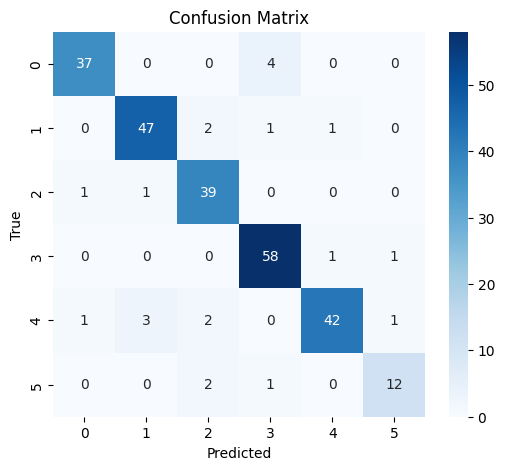

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()